In this notebook, we explore the effects of correlations between regressors in multiple regression.

In [2]:
import numpy,pandas
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing

%matplotlib inline

/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


First let's modify our data generation code from the LinearAlgebraGLM notebook, to generate correlated regressors. 

In [5]:
def make_regression_data_corr(beta=[10,0.1,0.5],nobs=100,
                         noisesd=1.,
                         regcorr=0):
    """
    function to generate regression data 
    with option to add correlation between regressors
    beta reflects two conditions plus intercept
    """
    
    # convert the correlation to a covariance matrix
    cor=numpy.array([[1.,regcorr],[regcorr,1.]])
    var=numpy.array([[1,0],[0,1]])
    cov=var.dot(cor).dot(var)

    regs=numpy.random.multivariate_normal([0,0],cov,nobs)
    regs=sklearn.preprocessing.scale(regs)
    regs=sm.add_constant(regs)

    data=regs.dot(numpy.array(beta))
    noise=numpy.random.randn(len(data))*noisesd
    y=data+noise
        
    return y,regs

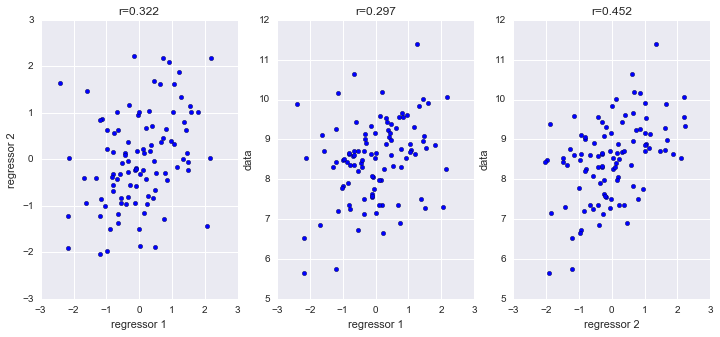

In [6]:
beta=[10,0.1,0.5]
d,r=make_regression_data_corr(beta,regcorr=0.5)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(r[:,1],r[:,2])
plt.xlabel('regressor 1')
plt.ylabel('regressor 2')
plt.title('r=%0.3f'%numpy.corrcoef(r[:,1],r[:,2])[0,1])
plt.subplot(1,3,2)
plt.scatter(r[:,1],d)
plt.xlabel('regressor 1')
plt.ylabel('data')
plt.title('r=%0.3f'%numpy.corrcoef(r[:,1],d)[0,1])
plt.subplot(1,3,3)
plt.scatter(r[:,2],d)
plt.xlabel('regressor 2')
plt.ylabel('data')
plt.title('r=%0.3f'%numpy.corrcoef(r[:,2],d)[0,1])



Now let's simulate data with varying levels of correlation between regressors, and see what it does to the performance of the model.  In partiuclar, we are interested in the variance of the parameter estimates.  Theoretically, we expect that variance should increase as a function of correlation between the regressors, according to the Variance Inflation Factor:

$VIF_i = \frac{1}{1 - R^2_i}$

where $R^2_i$ is the r-squared for variable i against the other variables. In this case, since there are two variables, it's just the squared correlation between those variables.

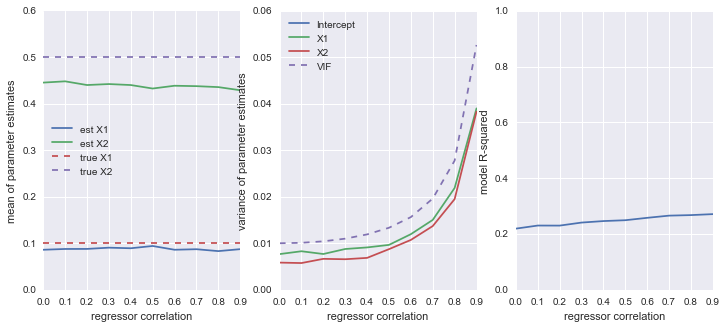

In [8]:
nruns=1000
ncorrvals=numpy.arange(0,1,0.1)

bhat=numpy.zeros((len(ncorrvals),nruns,3))
bhat_ridge=numpy.zeros((len(ncorrvals),nruns,3))

rsq=numpy.zeros((len(ncorrvals),nruns))

ridge_lambda=0.2

for c in range(len(ncorrvals)):
    for i in range(nruns):
        Y,X=make_regression_data_corr(regcorr=ncorrvals[c])
        ols_result=sm.OLS(Y,X).fit()
        ridge_result=sm.OLS(Y,X).fit_regularized(L1_wt=0,alpha=ridge_lambda)
        bhat[c,i,:]=ols_result.params
        bhat_ridge[c,i,:]=ridge_result.params
        rsq[c,i]=ols_result.rsquared


   
mean_bhat=pandas.DataFrame(numpy.mean(bhat,1),columns=['Intercept','X1','X2'])
var_bhat=pandas.DataFrame(numpy.var(bhat,1),columns=['Intercept','X1','X2'])
mean_bhat_ridge=pandas.DataFrame(numpy.mean(bhat_ridge,1),columns=['Intercept','X1','X2'])
var_bhat_ridge=pandas.DataFrame(numpy.var(bhat_ridge,1),columns=['Intercept','X1','X2'])

mean_rsq=numpy.mean(rsq,1)


plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(ncorrvals,mean_bhat.ix[:,1:])
plt.plot(ncorrvals,numpy.ones((10,2))*beta[1:],'--')
plt.xlabel('regressor correlation')
plt.ylabel('mean of parameter estimates')
plt.legend(['est X1','est X2','true X1','true X2'],loc=6)
plt.ylim([0,0.6])

plt.subplot(1,3,2)
plt.plot(ncorrvals,var_bhat)
plt.plot(ncorrvals,0.01/(1-ncorrvals**2),'--')
plt.xlabel('regressor correlation')
plt.ylabel('variance of parameter estimates')
plt.legend(['Intercept','X1','X2','VIF'],loc=2)
plt.ylim([0,0.06])


plt.subplot(1,3,3)
plt.plot(ncorrvals,mean_rsq)
plt.ylim([0,1])
plt.ylabel('model R-squared')
plt.xlabel('regressor correlation')



One way to deal with correlated regressors is to use an estimation method that trades a bit of bias to reduce the variance of the estimates.  A simple version of this is ridge regression.  Remember the estimator for ordinary least squares:

$\hat{B} = (X'X)^{-1}X'Y$

Ridge regression is similar, but adds a constant to the diagonal to the covariance matrix:

$\hat{B}_{ridge} = (X'X + \lambda I)^{-1}X'Y$

This is equivalent to penalizing the total sum of squares of parameter estimates, which will tend to reduce the estimates. Let's plot those estimates and their variance:



(0, 0.06)

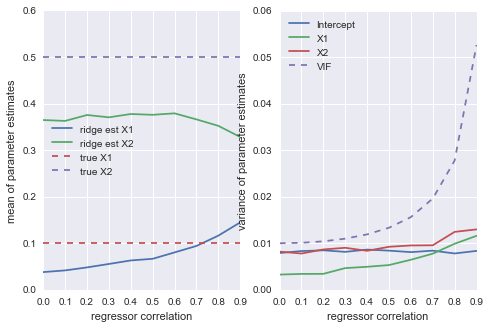

In [109]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(ncorrvals,mean_bhat_ridge.ix[:,1:])

#plt.plot(ncorrvals,mean_bhat.ix[:,1:])
plt.plot(ncorrvals,numpy.ones((10,2))*beta[1:],'--')
plt.xlabel('regressor correlation')
plt.ylabel('mean of parameter estimates')
plt.legend(['ridge est X1','ridge est X2','true X1','true X2'],loc=6)
plt.ylim([0,0.6])

plt.subplot(1,3,2)
plt.plot(ncorrvals,var_bhat_ridge)
#plt.plot(ncorrvals,var_bhat)
plt.plot(ncorrvals,0.01/(1-ncorrvals**2),'--')
plt.xlabel('regressor correlation')
plt.ylabel('variance of parameter estimates')
plt.legend(['Intercept','X1','X2','VIF'],loc=2)
plt.ylim([0,0.06])




__Exercise__: Run the simulation with a few different lambda values. How do the mean and variance change?  How might you determine an optimal lambda value for a given dataset?